In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import re 
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
import warnings
warnings.filterwarnings('ignore')

In [2]:
# pip install amazon-product-review-scraper
# from amazon_product_review_scraper import amazon_product_review_scraper

In [3]:
#review_scraper = amazon_product_review_scraper(amazon_site= "amazon.in", product_asin ="B086KCCSDD")
# reviews_df = review_scraper.scrape()
# reviews_df.to_csv('reviews.csv')

In [4]:
reviews = pd.read_csv('reviews.csv')
reviews.head()

,Unnamed: 0,date_info,name,title,content,rating
0,0,Reviewed in India on 14 October 2020,Vignesh,Amazing design! Best NON CHINESE phone in this...,This the best ever non Chinese budget phone yo...,4.0 out of 5 stars
1,1,Reviewed in India on 5 July 2020,Atluri Karthik,Samsung Galaxy M11 sensor issue and no replace...,My mobile is 1week old.There is sensor issue.....,1.0 out of 5 stars
2,2,Reviewed in India on 31 July 2020,Priyanka M.,Phone for office use and multitasking but not ...,I have used the phone one week and then writin...,4.0 out of 5 stars
3,3,Reviewed in India on 1 January 2021,VIRENDRA SINGH MAHIDA,Feeling cheated,The cellphone was unpacked and switched on day...,1.0 out of 5 stars
4,4,Reviewed in India on 25 January 2021,jyothi prasanna,Buy something else.,I ordered this mobile for my mother who uses o...,1.0 out of 5 stars


In [5]:
df = reviews.drop('Unnamed: 0', axis = 1)
df.head()

,date_info,name,title,content,rating
0,Reviewed in India on 14 October 2020,Vignesh,Amazing design! Best NON CHINESE phone in this...,This the best ever non Chinese budget phone yo...,4.0 out of 5 stars
1,Reviewed in India on 5 July 2020,Atluri Karthik,Samsung Galaxy M11 sensor issue and no replace...,My mobile is 1week old.There is sensor issue.....,1.0 out of 5 stars
2,Reviewed in India on 31 July 2020,Priyanka M.,Phone for office use and multitasking but not ...,I have used the phone one week and then writin...,4.0 out of 5 stars
3,Reviewed in India on 1 January 2021,VIRENDRA SINGH MAHIDA,Feeling cheated,The cellphone was unpacked and switched on day...,1.0 out of 5 stars
4,Reviewed in India on 25 January 2021,jyothi prasanna,Buy something else.,I ordered this mobile for my mother who uses o...,1.0 out of 5 stars


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date_info  531 non-null    object
 1   name       531 non-null    object
 2   title      531 non-null    object
 3   content    531 non-null    object
 4   rating     531 non-null    object
dtypes: object(5)
memory usage: 20.9+ KB


# Preprocessing Data

* Cleaning Data

In [7]:
# Cleaning Rating

df.rating = df.rating.apply(lambda x : x.replace(' out of 5 stars',''))
df.rating.astype('float')

0      4.0
1      1.0
2      4.0
3      1.0
4      1.0
      ... 
526    4.0
527    1.0
528    1.0
529    5.0
530    5.0
Name: rating, Length: 531, dtype: float64

In [8]:
# Cleaning up the Dates and making a seperate columns for country
df.date_info = df.date_info.apply(lambda x : x.replace('Reviewed in ',''))
df.date_info = df.date_info.apply(lambda x : re.sub(r"on ", "", x))

# For Country
df["country"] = df.date_info.apply(lambda x : x.split(' ',1)[0])

# Splitting date
df.date_info = df.date_info.apply(lambda x : x.split(' ',1)[1])

In [9]:
# Fixing the dates

from datetime import datetime

reps = {'March':'Mar','April':'Apr','May':'May','June':'Jun','July':'Jul','August':'Aug','September':'Sep',
          'October':'Oct','November':'Nov','December':'Dec','January':'Jan','February':'Feb'}
df.date_info = df.date_info.replace(reps, regex = True)
df.date_info = df.date_info.apply(lambda x : datetime.strptime(x, '%d %b %Y'))

In [10]:
df1 = df.copy()
df1 = df1.drop(['name','content'], axis = 1)
df1.head()

,date_info,title,rating,country
0,2020-10-14,Amazing design! Best NON CHINESE phone in this...,4.0,India
1,2020-07-05,Samsung Galaxy M11 sensor issue and no replace...,1.0,India
2,2020-07-31,Phone for office use and multitasking but not ...,4.0,India
3,2021-01-01,Feeling cheated,1.0,India
4,2021-01-25,Buy something else.,1.0,India


In [11]:
df1.title = df1.title.apply(lambda x: ' '.join([word for word in x.split() if word not in (STOPWORDS)]))
df1.head()

,date_info,title,rating,country
0,2020-10-14,Amazing design! Best NON CHINESE phone range.,4.0,India
1,2020-07-05,Samsung Galaxy M11 sensor issue replacement,1.0,India
2,2020-07-31,Phone office use multitasking photography.,4.0,India
3,2021-01-01,Feeling cheated,1.0,India
4,2021-01-25,Buy something else.,1.0,India


# Product Sentiment Values

In [12]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentialz = SentimentIntensityAnalyzer()
sentialz.polarity_scores(df.title.iloc[2])

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [13]:
#Function to retrieve sentiment class

def get_senti_class(review): 
    analysis = sentialz.polarity_scores(review)
    # set sentiment 
    if analysis["compound"] > 0: 
        return 'positive'
    elif analysis["compound"] < 0: 
        return 'negative'
    else: 
        return 'neutral'
    
def get_sentiment(review):
    return pd.Series([sentialz.polarity_scores(review),get_senti_class(review)])

In [14]:
df1[["Scores", "Sentiment"]] = df1.title.apply(get_sentiment)
df1.head()

,date_info,title,rating,country,Scores,Sentiment
0,2020-10-14,Amazing design! Best NON CHINESE phone range.,4.0,India,"{'neg': 0.0, 'neu': 0.376, 'pos': 0.624, 'comp...",positive
1,2020-07-05,Samsung Galaxy M11 sensor issue replacement,1.0,India,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
2,2020-07-31,Phone office use multitasking photography.,4.0,India,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral
3,2021-01-01,Feeling cheated,1.0,India,"{'neg': 0.688, 'neu': 0.0, 'pos': 0.312, 'comp...",negative
4,2021-01-25,Buy something else.,1.0,India,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral


# Emotion Mining

In [15]:
df1.Sentiment.value_counts()

positive    315
neutral     141
negative     75
Name: Sentiment, dtype: int64

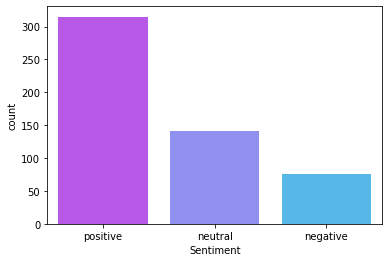

In [16]:
sns.countplot(df1.Sentiment,palette='cool_r');

In [17]:
df1.loc[df1.Sentiment == 'negative'].rating.value_counts()

1.0    46
2.0    13
4.0     7
3.0     6
5.0     3
Name: rating, dtype: int64

In [18]:
df1.loc[df1.Sentiment == 'negative'].loc[df1.rating == '5.0']

,date_info,title,rating,country,Scores,Sentiment
171,2021-06-21,Camera quality low,5.0,India,"{'neg': 0.512, 'neu': 0.488, 'pos': 0.0, 'comp...",negative
400,2021-06-06,No,5.0,India,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...",negative
411,2021-06-07,No,5.0,India,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...",negative


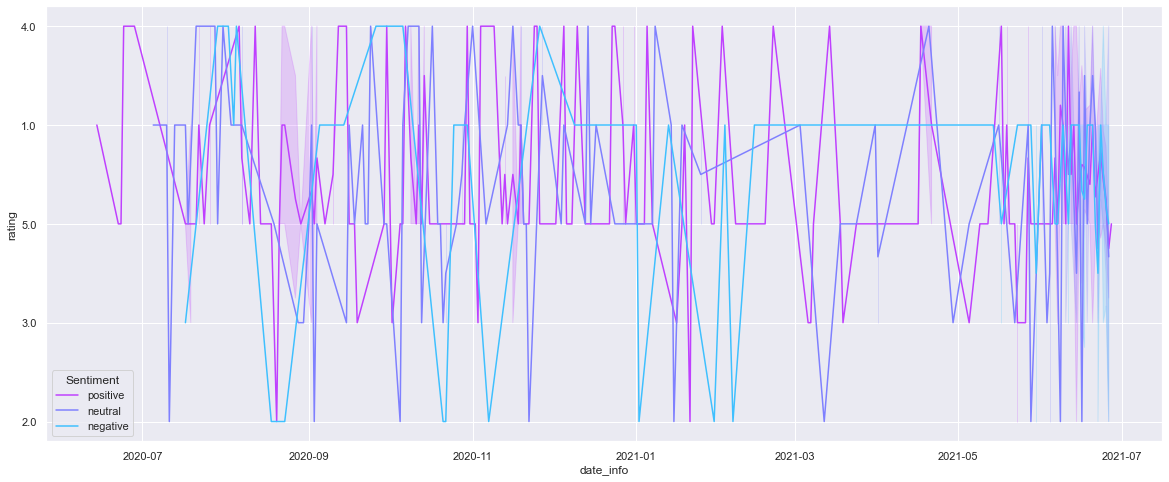

In [19]:
sns.set(rc = {'figure.figsize':(20,8)})
sns.lineplot(x = df1.date_info, y = df1.rating, data = df1, hue = df1.Sentiment, palette = 'cool_r')
plt.show()

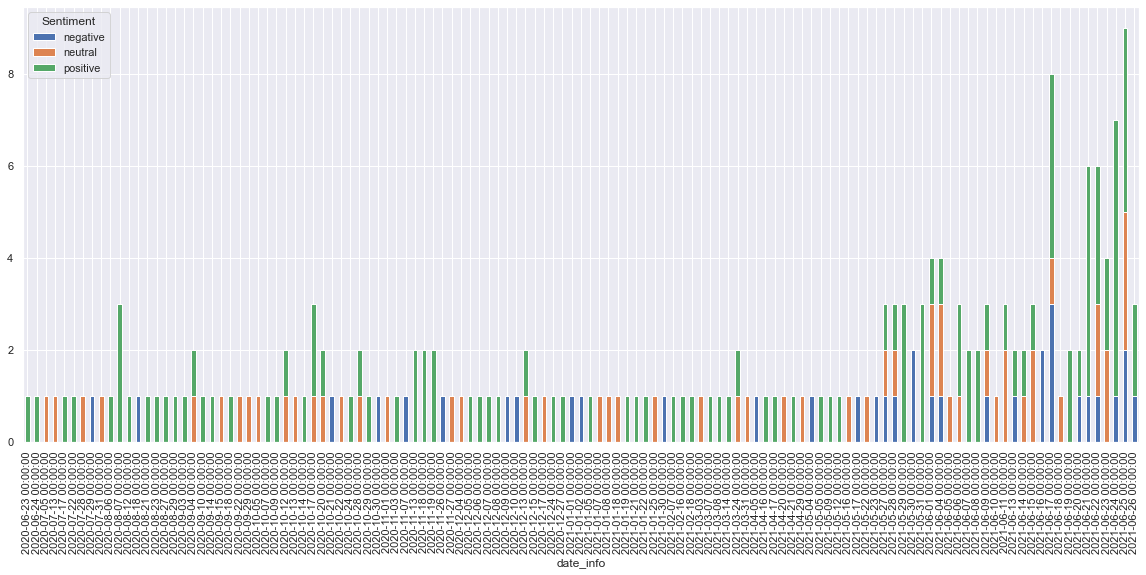

In [20]:
df1.date_info = pd.to_datetime(df1.date_info)
pd.crosstab(df1.date_info.iloc[:200], df1.Sentiment).plot.bar(stacked = True);

# Word Cloud

In [21]:
review_str = ' '.join(df1['title'].tolist())

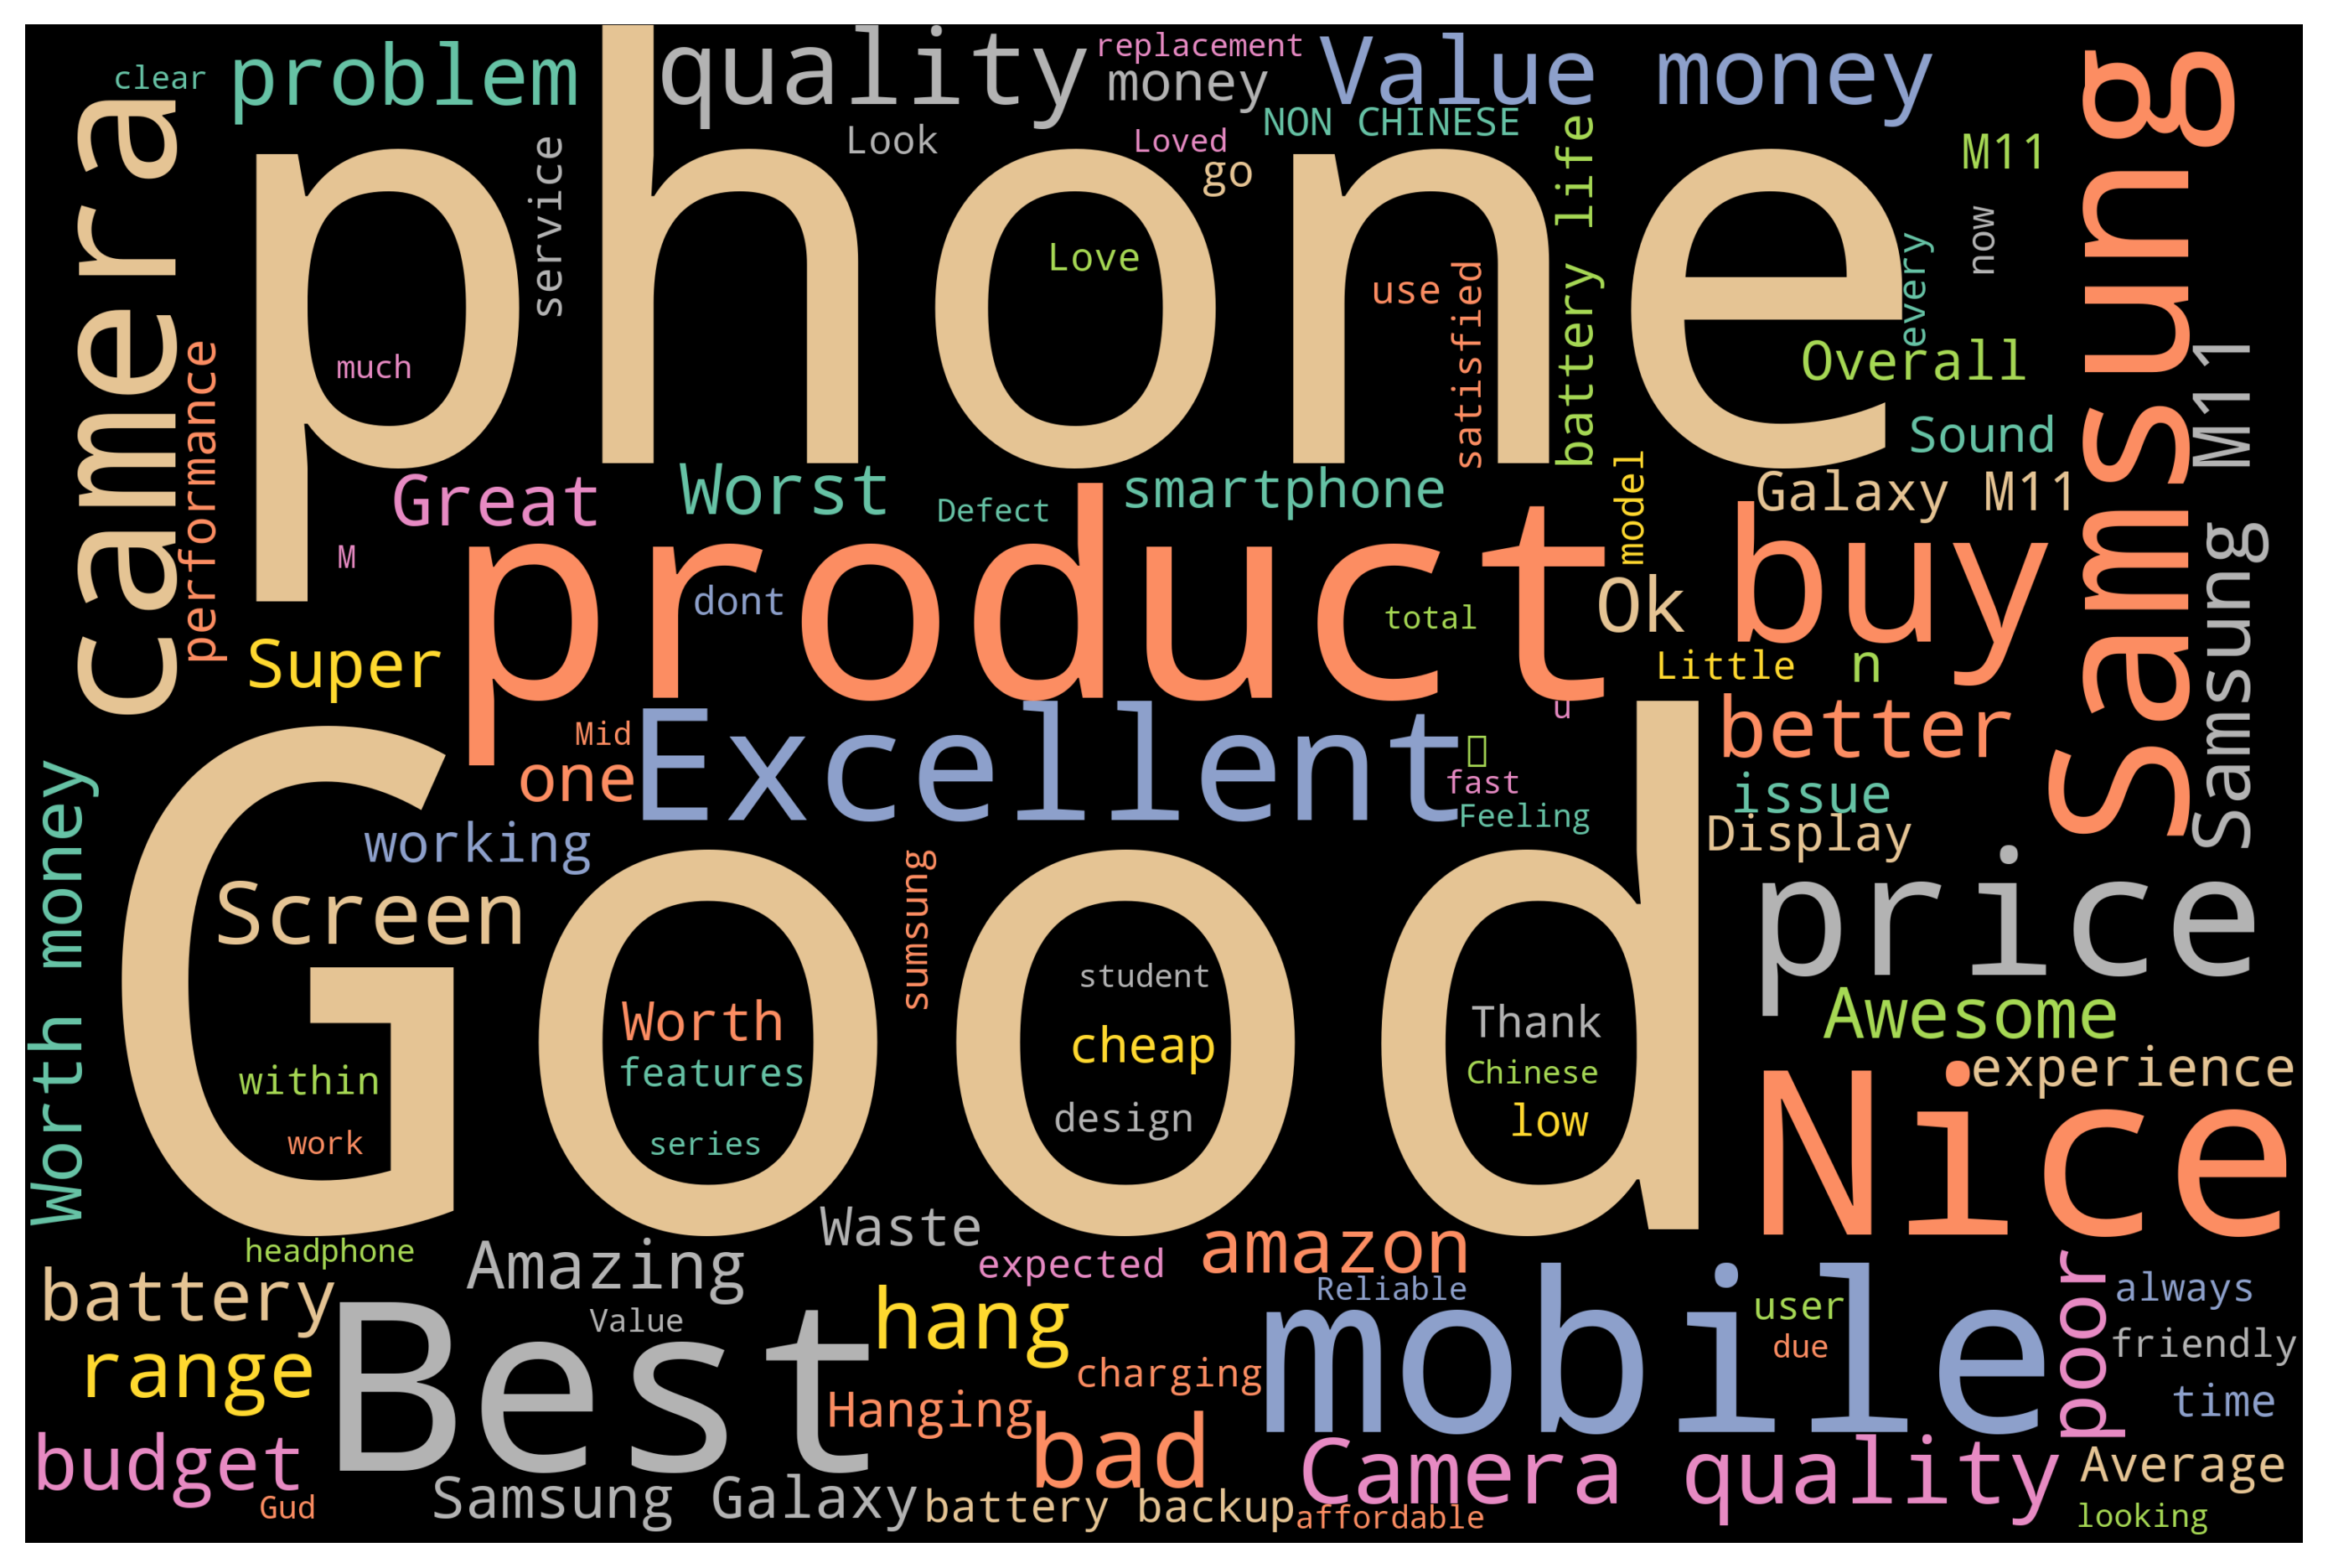

In [22]:
# Creating a WordCloud

wordcloud_ip = WordCloud(width = 3000, height = 2000, background_color = "black", max_words = 100, colormap = 'Set2').generate(review_str)
figure(figsize = (15,8), dpi = 300)
plt.imshow(wordcloud_ip,interpolation = "bilinear")
plt.axis("off")
plt.show()

* Positive & Negative Words

In [23]:
with open('positive-words.txt', 'r') as poswords:
    positive = poswords.read().split("\n")
    
with open('negative-words.txt', 'r') as negwords:
    negative = negwords.read().split("\n")

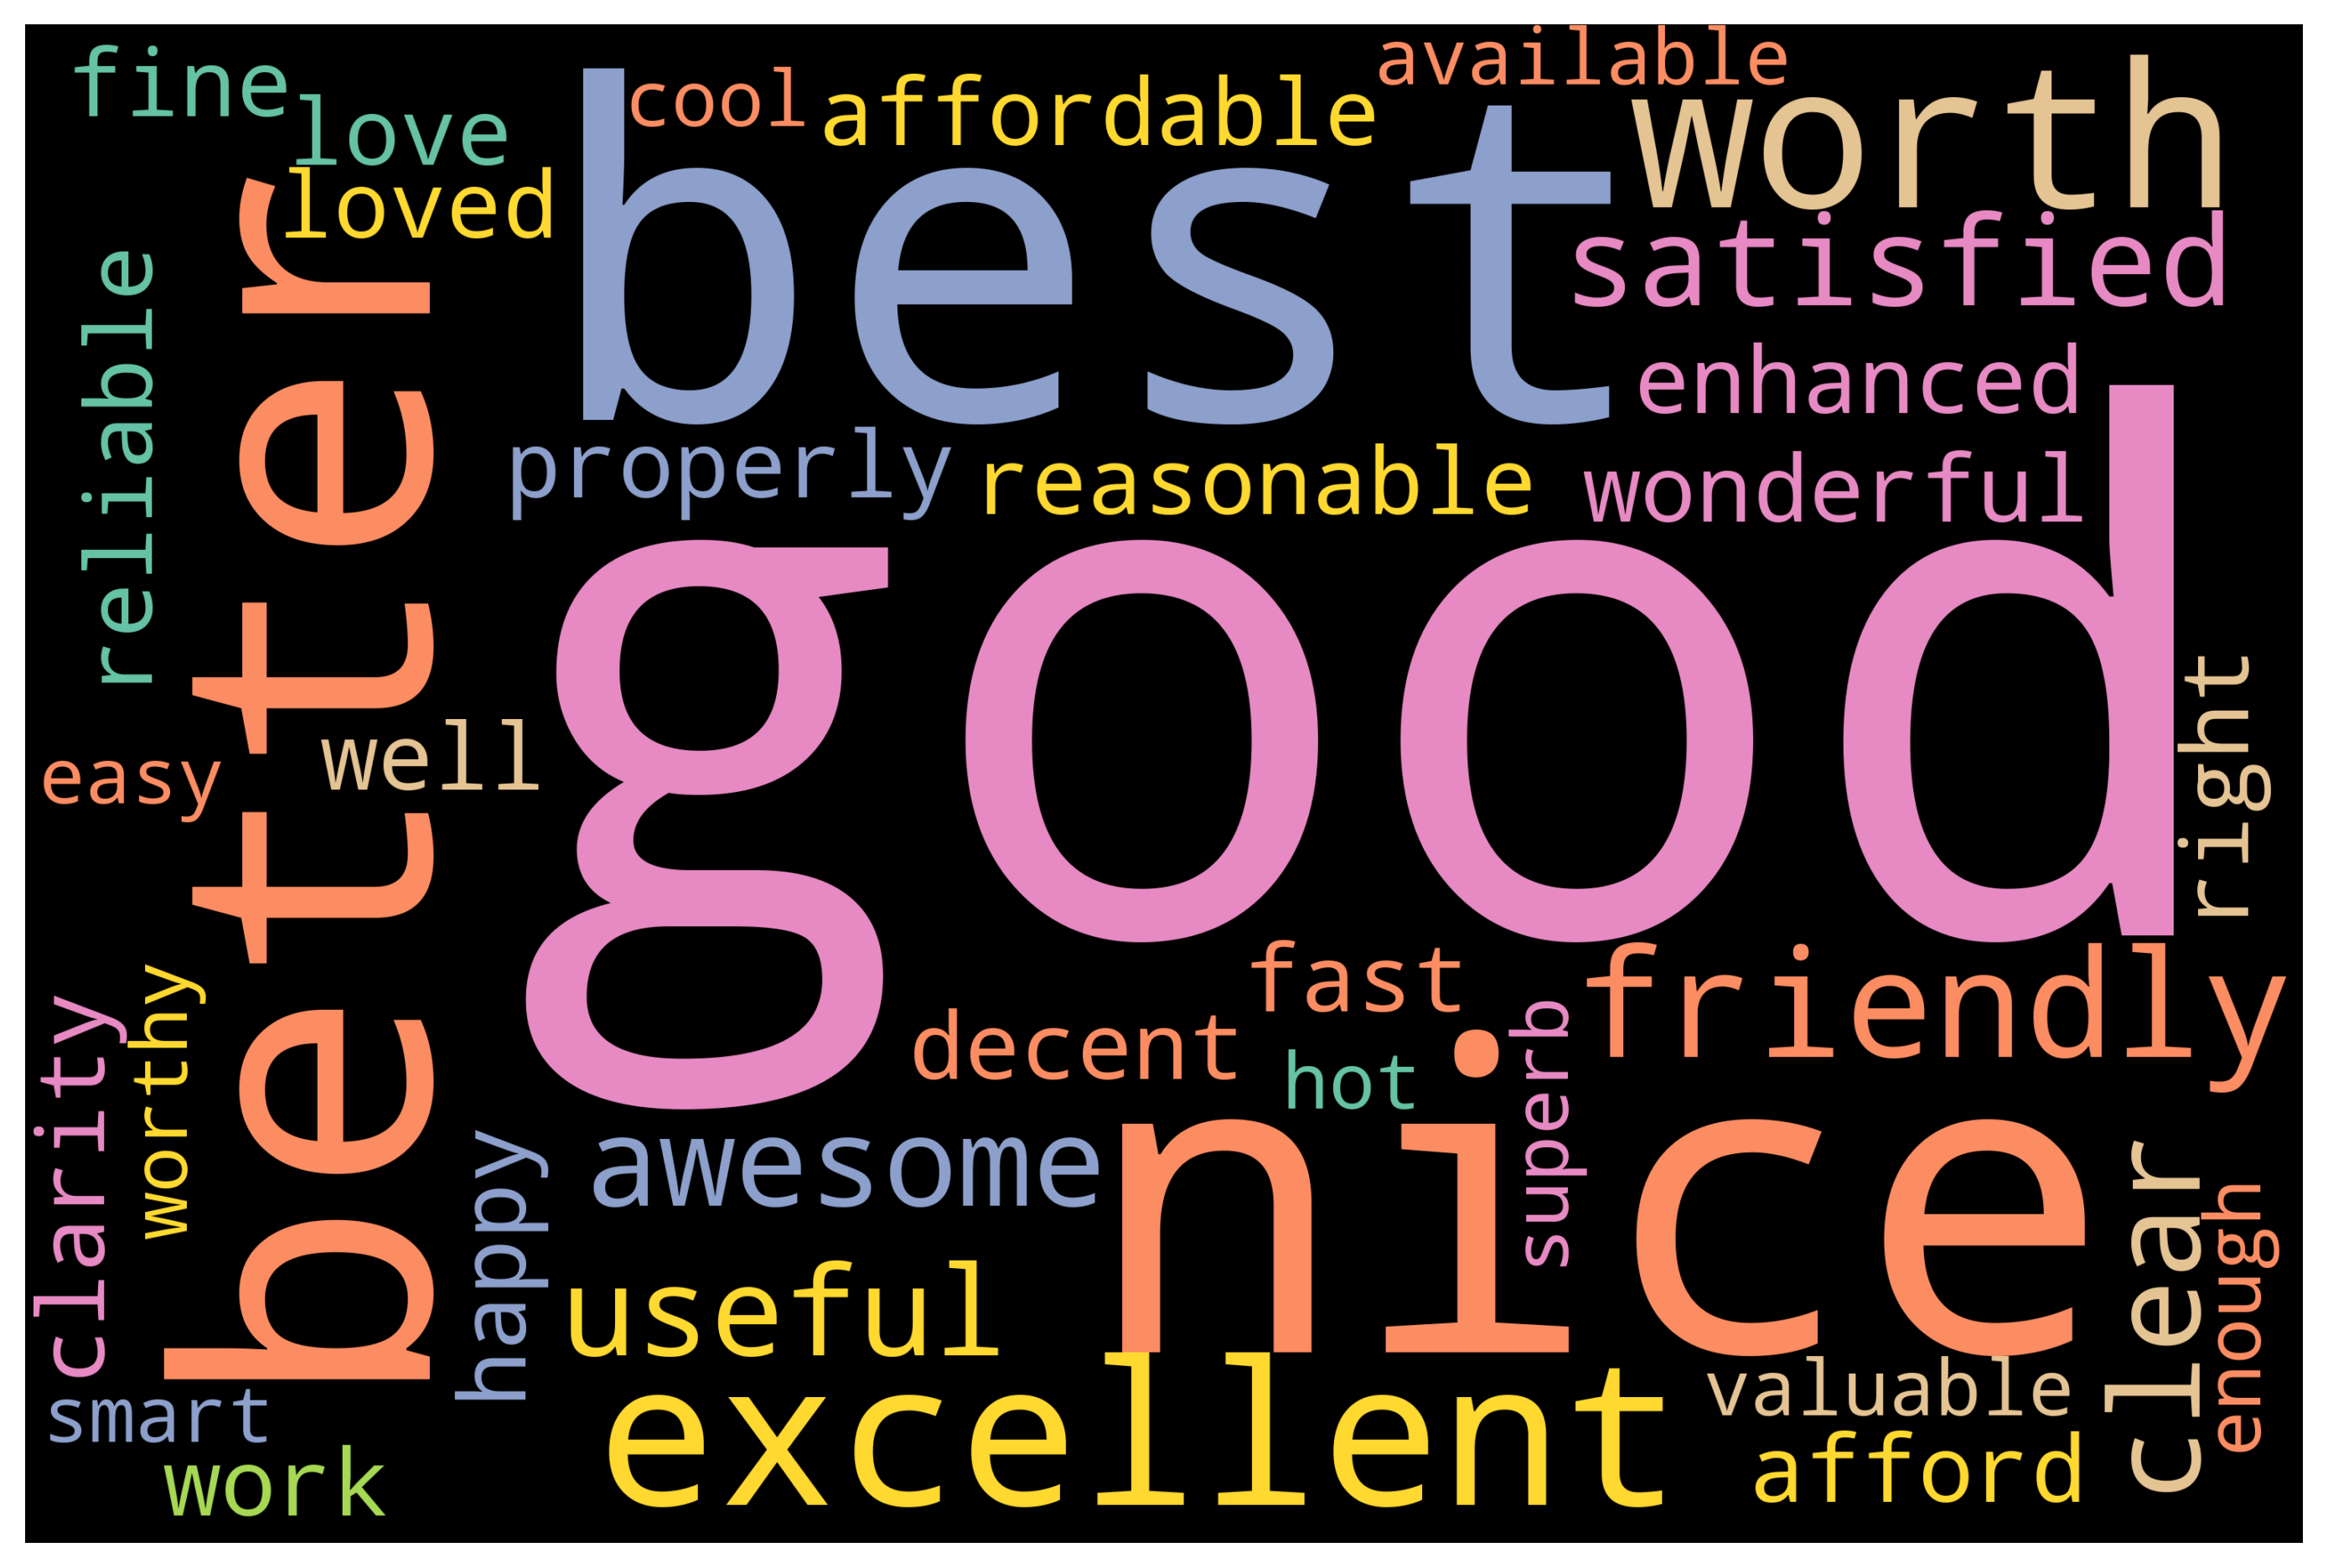

In [24]:
# Positive Word Cloud

posi = " ".join ([w for w in review_str.split() if w in positive])

wordcloud_ip = WordCloud(width = 3000, height = 2000, background_color = "black", colormap = 'Set2').generate(posi)
figure(figsize = (15,8), dpi = 300)
plt.imshow(wordcloud_ip,interpolation = "bilinear")
plt.axis("off")
plt.show()

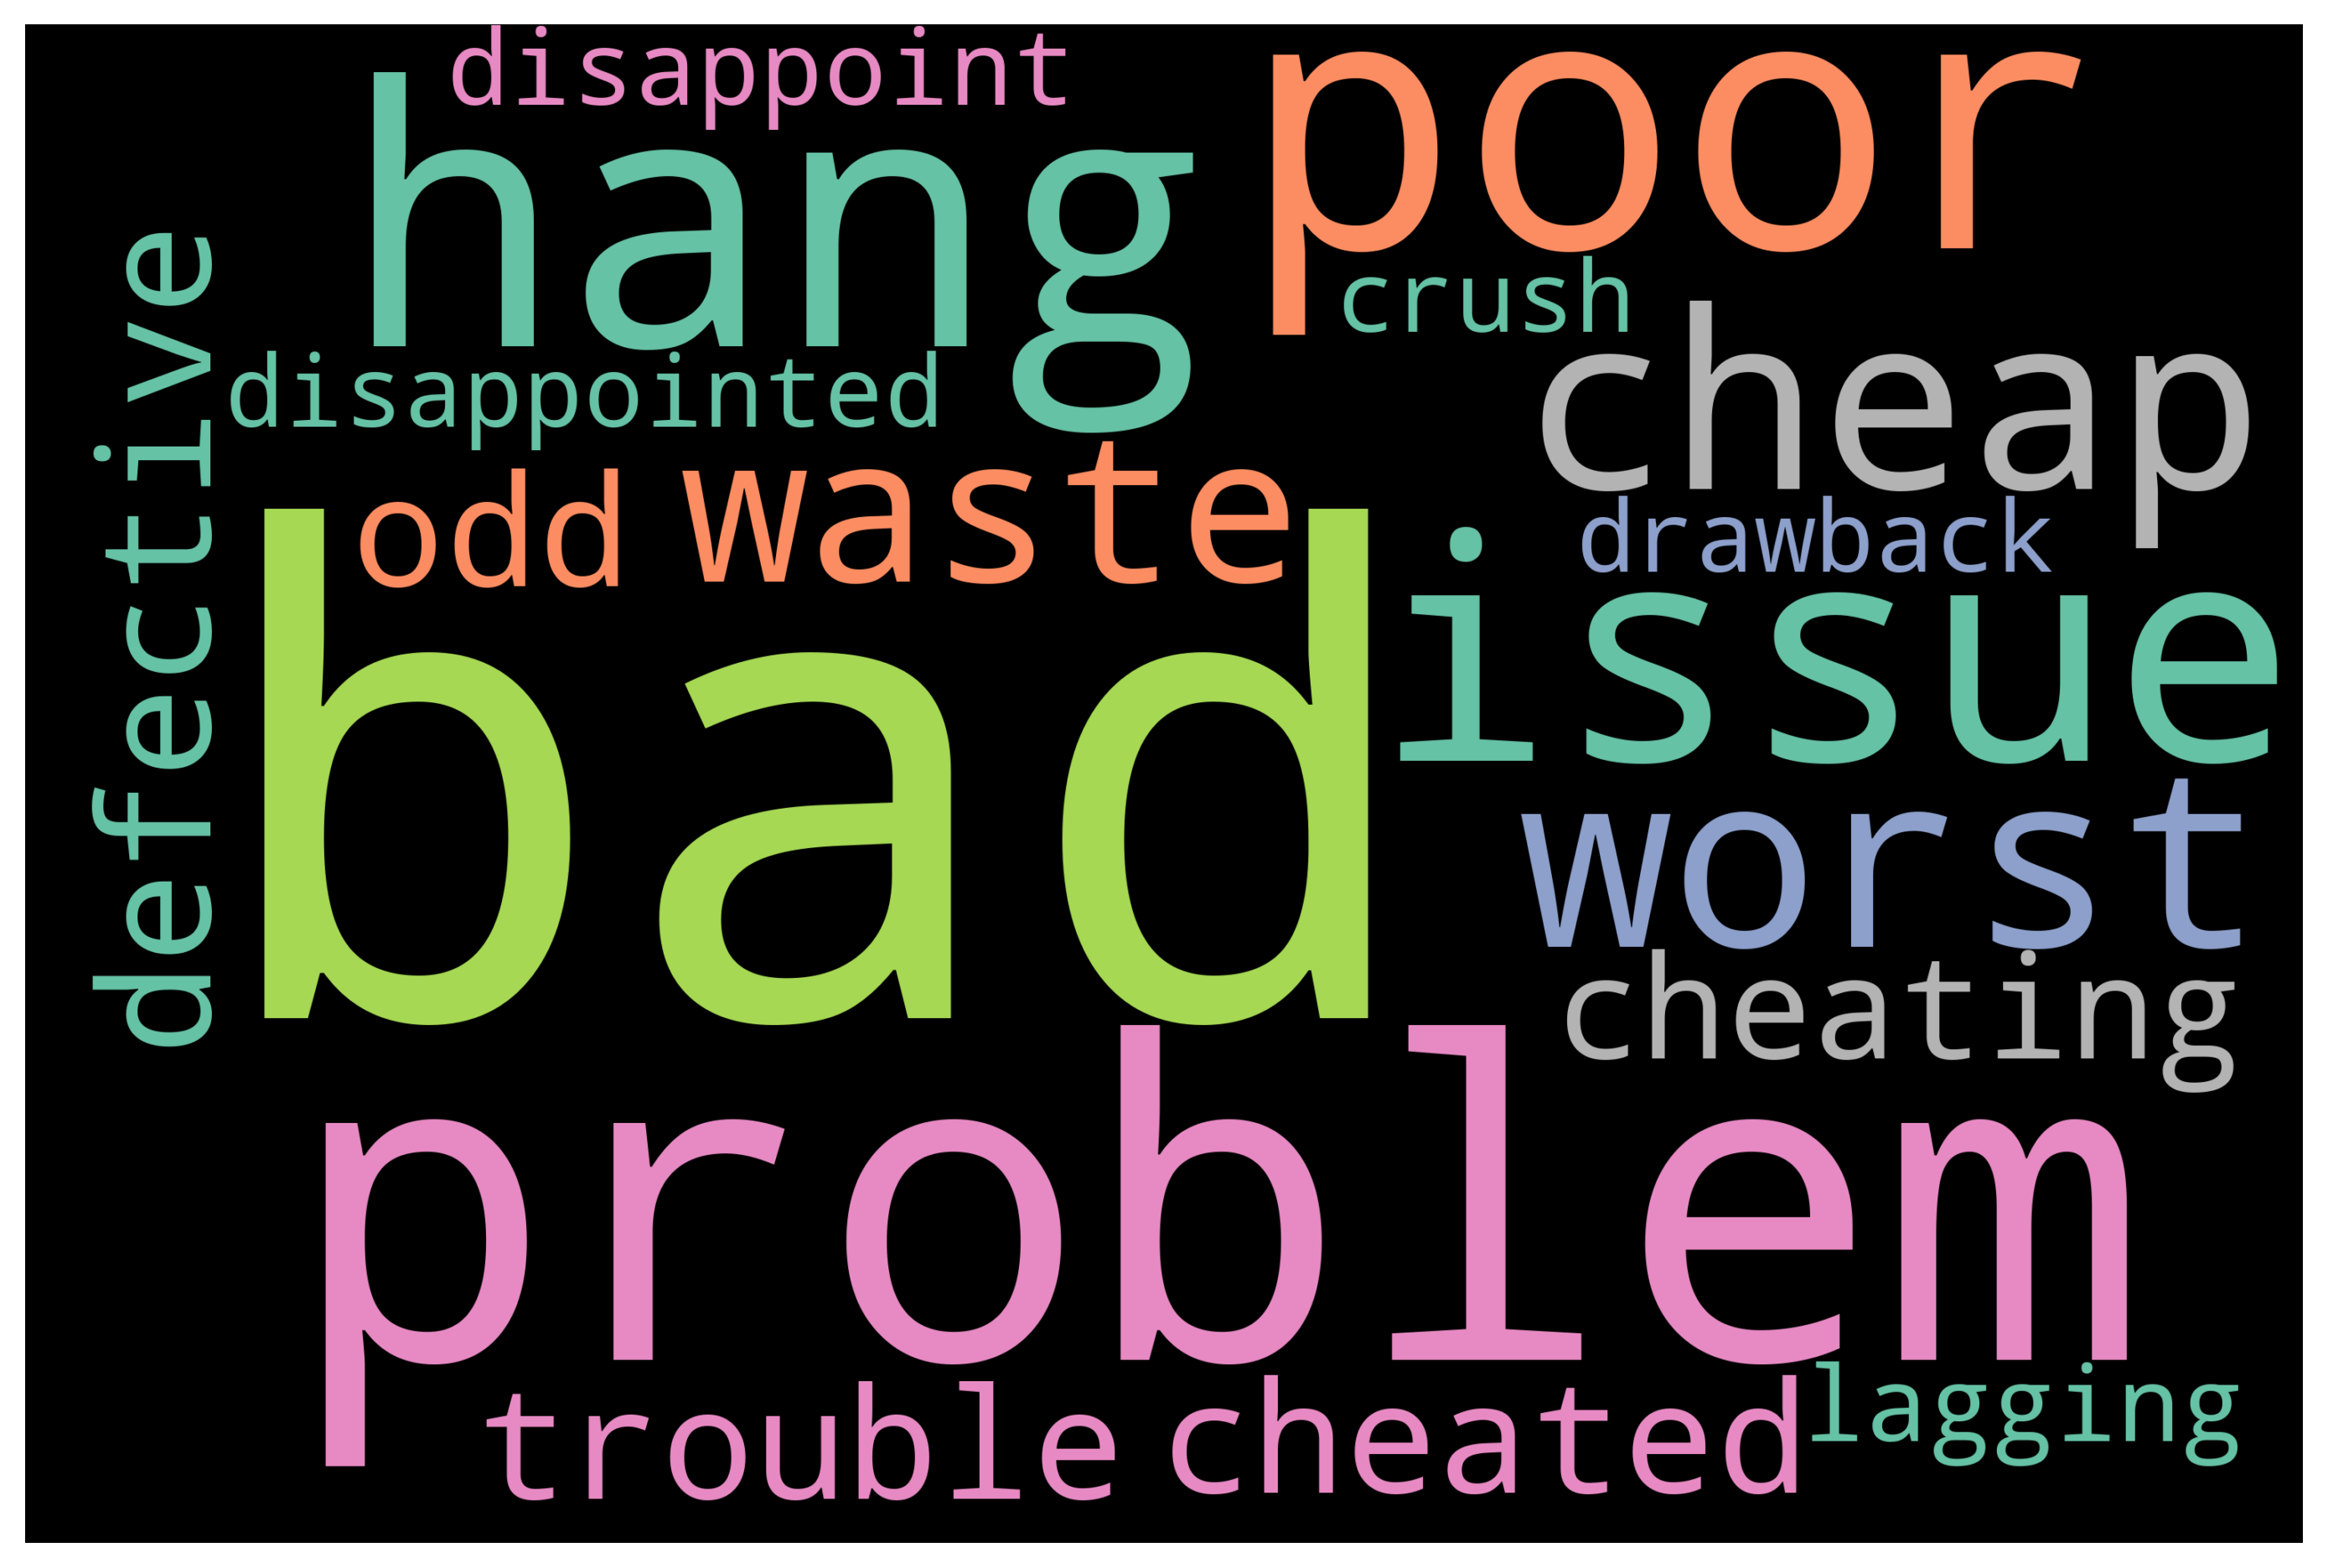

In [25]:
# Negative Word Cloud

nega = " ".join ([w for w in review_str.split() if w in negative])

wordcloud_ip = WordCloud(width = 3000, height = 2000, background_color = "black", colormap = 'Set2').generate(nega)
figure(figsize = (15,8), dpi = 300)
plt.imshow(wordcloud_ip,interpolation = "bilinear")
plt.axis("off")
plt.show()